# Check sync process

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datetime
import pathlib
import numpy as np
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal as sp


from u19_pipeline.ephys_pipeline import ephys_element, probe_element, get_session_directory, get_ephys_root_data_dir
import u19_pipeline.utils.ephys_fix_sync_code as ephys_fix_sync_code
import u19_pipeline.acquisition as acquisition
import datajoint as dj

from element_interface.utils import find_full_path

import u19_pipeline.utils.DemoReadSGLXData.readSGLX as readSGLX
import u19_pipeline.utils.ephys_utils as ephys_utils


[2026-01-27 09:26:40,365][INFO]: DataJoint 0.14.4 connected to alvaros@datajoint00.pni.princeton.edu:3306


In [3]:
recording_query = "recording_id = 502"
recording = dj.create_virtual_module('recording', 'u19_recording')
recording_key = (recording.Recording & recording_query).fetch('recording_id', as_dict=True, order_by='recording_id')


key = (recording.Recording.BehaviorSession & recording_query).fetch1()
del key['recording_id']

key

{'subject_fullname': 'jyanar_ya054',
 'session_date': datetime.date(2025, 10, 10),
 'session_number': 0}

In [4]:
session_dir = pathlib.Path(get_session_directory(recording_key[0]))
session_dir


PosixPath('jyanar/jyanar_ya054/20251010_g0/ya054_20251010_g0')

In [5]:
session_dir = find_full_path(get_ephys_root_data_dir(),
                            get_session_directory(recording_key))
print(session_dir)
#session_dir = pathlib.Path('/Users/alvaros/Documents/MATLAB/BrainCogsProjects/CalciumImagingData/test_g0/')
#Check if session is Nidq or OneBox
nidq_session = list(session_dir.glob('*nidq.bin*'))
obx_session = list(session_dir.glob('*obx.bin*'))

if len(nidq_session) == 0 and len(obx_session) == 0:
    print('No session found')
elif len(nidq_session) > 0:
    ephys_session_fullpath = nidq_session[0]
else:
    ephys_session_fullpath = obx_session[0]

#Nidaq file
nidq_meta          = readSGLX.readMeta(ephys_session_fullpath)
nidq_sampling_rate = readSGLX.SampRate(nidq_meta)


# 1: load meta data, and the content of the NIDAQ file. Its content is digital.            
new_trial_channel = 1
new_iteration_channel = 2
# If PXIe card (nidq) card use for recording deduce digital channels
if nidq_meta['typeThis'] == 'nidq':
    digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta)
# If onebox card (obx) card use for recording digital channels are 0-2
else:
    digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta, d_line_list=[0,1])
    # If no sync pulse found trial and iteration signals are 0 & 1 respectively
    channel0_pulses = np.where(np.diff(digital_array[0])==1)[0].shape[0]
    channel1_pulses = np.where(np.diff(digital_array[1])==1)[0].shape[0]

    if channel0_pulses > channel1_pulses:
        new_trial_channel = 1
        new_iteration_channel = 0
    else:
        new_trial_channel = 0
        new_iteration_channel = 1

/mnt/cup/braininit/Data/Raw/electrophysiology/jyanar/jyanar_ya054/20251010_g0/ya054_20251010_g0
nChan: 4, nFileSamp: 118289333


# Synchronize ePhys and Behavior

Populate the tables, using the nidaq file produced by spikeGLX. This is done automatically and produces a record of VR iteration numbers measured in the time of the ePhys setup.

### Read nidaq file and behavior data

In [6]:
#Behavior data
behavior_key = key.copy()
behavior = dj.create_virtual_module('behavior', 'u19_behavior')

block = 0
# If a specific block is requested, add that to our behavior_key. It should be an int referring to virmen block number.
# This is useful for sessions in which the nidaq stream was interrupted due to restarting virmen
if block > 0:
    behavior_key['block'] = block

thissession = behavior.TowersBlock().Trial() & behavior_key
behavior_time, iterstart, beh_num_iterations = thissession.fetch('trial_time', 'vi_start', 'iterations')


### Get samples and times where trials and iterations start

In [7]:
mode = None   #Default for sessions before 12/01/2021
#mode = 'pulses'    #Default for sessions after 12/01/2021
iteration_dict = ephys_utils.get_iteration_sample_vector_from_digital_lines_pulses(digital_array[new_trial_channel,:], digital_array[new_iteration_channel,:], nidq_sampling_rate, behavior_time.shape[0], behavior_time, mode=mode)
#                             get_iteration_sample_vector_from_digital_lines_pulses(trial_pulse_signal, iteration_pulse_signal,


# Check # of trials and iterations match
trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small = ephys_utils.assert_iteration_samples_count(iteration_dict['iter_start_idx'], behavior_time)

print(trial_count_diff)
print(trials_diff_iteration_big)
print(trials_diff_iteration_small)


status = ephys_utils.evaluate_sync_process(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small,  behavior_time.shape[0])


len trial_start_idx (309,)
mode deduction:  pulse_signal
trial# 2 iterPulses: 526 IterBeh: 527 Difference ( 1 )
trial# 3 iterPulses: 460 IterBeh: 525 Difference ( 65 )
trial# 27 iterPulses: 962 IterBeh: 965 Difference ( 3 )
trial# 32 iterPulses: 934 IterBeh: 935 Difference ( 1 )
trial# 35 iterPulses: 560 IterBeh: 561 Difference ( 1 )
trial# 40 iterPulses: 473 IterBeh: 474 Difference ( 1 )
trial# 51 iterPulses: 511 IterBeh: 512 Difference ( 1 )
trial# 60 iterPulses: 550 IterBeh: 551 Difference ( 1 )
trial# 77 iterPulses: 455 IterBeh: 456 Difference ( 1 )
trial# 81 iterPulses: 520 IterBeh: 521 Difference ( 1 )
trial# 84 iterPulses: 470 IterBeh: 472 Difference ( 2 )
trial# 85 iterPulses: 519 IterBeh: 520 Difference ( 1 )
trial# 89 iterPulses: 489 IterBeh: 490 Difference ( 1 )
trial# 91 iterPulses: 947 IterBeh: 948 Difference ( 1 )
trial# 95 iterPulses: 662 IterBeh: 663 Difference ( 1 )
trial# 114 iterPulses: 548 IterBeh: 552 Difference ( 4 )
trial# 115 iterPulses: 462 IterBeh: 463 Differe

In [8]:
trial_fix = 3
synced_iteration_vector = iteration_dict['iter_start_idx'][trial_fix]
synced_time_vector = iteration_dict['iter_times_idx'][trial_fix]

behavior_time_vector = behavior_time[trial_fix].flatten()

synced_time_vector = synced_time_vector+behavior_time_vector[2]
print(synced_time_vector[0:5])
print(behavior_time_vector[0:5])

[0.0251116 0.0325036 0.0399616 0.0523696 0.0690676]
[0.        0.0177847 0.0251116 0.0418594 0.0585367]


In [9]:
behavior_time_vector.shape

(525,)

In [10]:

'''
#synced_time_vector = synced_time_vector+behavior_time_vector[1]-(behavior_time_vector[2]-synced_time_vector[2])
synced_time_vector = synced_time_vector+behavior_time_vector[1]
synced_time_vector = np.insert(synced_time_vector, 1, behavior_time_vector[1])
synced_time_vector[2:] = synced_time_vector[2:]+(behavior_time_vector[2]-synced_time_vector[2])
synced_time_vector[0] = 0

if synced_time_vector.shape[0] > behavior_time_vector.shape[0]:
    synced_time_vector = synced_time_vector[:-1]


print(synced_time_vector[0:5])
print(behavior_time_vector[0:5])
'''

'\n#synced_time_vector = synced_time_vector+behavior_time_vector[1]-(behavior_time_vector[2]-synced_time_vector[2])\nsynced_time_vector = synced_time_vector+behavior_time_vector[1]\nsynced_time_vector = np.insert(synced_time_vector, 1, behavior_time_vector[1])\nsynced_time_vector[2:] = synced_time_vector[2:]+(behavior_time_vector[2]-synced_time_vector[2])\nsynced_time_vector[0] = 0\n\nif synced_time_vector.shape[0] > behavior_time_vector.shape[0]:\n    synced_time_vector = synced_time_vector[:-1]\n\n\nprint(synced_time_vector[0:5])\nprint(behavior_time_vector[0:5])\n'

[np.float64(0.008533848424048814), np.float64(0.015533848424048813), np.float64(0.022533848424048812)]


(-0.2, 1.0)

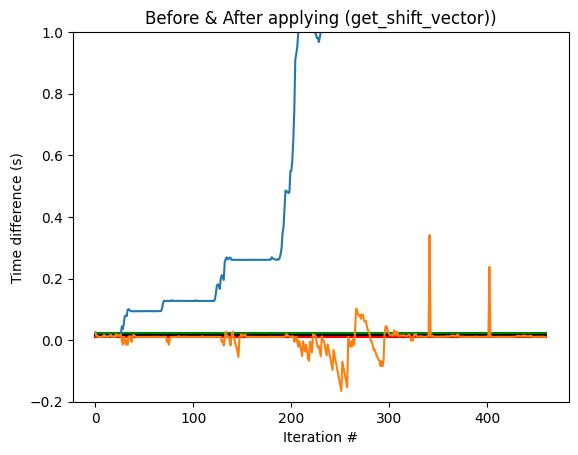

In [18]:

synced_time_vector2, shift_vec, median_vec = ephys_fix_sync_code.get_shift_vector(synced_time_vector,behavior_time_vector)

print(median_vec)



#median_diff = np.median(baseline_diff)
#max_diff = np.median(baseline_diff)+0.007
#min_diff = np.median(baseline_diff)-0.007
#time_vec = np.arange(base_size-initial_sample)
plt.plot([0, synced_time_vector.shape[0]], [median_vec[1], median_vec[1]],'k')
plt.plot([0, synced_time_vector.shape[0]], [median_vec[0], median_vec[0]],'r')
plt.plot([0, synced_time_vector.shape[0]], [median_vec[2], median_vec[2]],'g')

plt.plot(synced_time_vector - behavior_time_vector[:synced_time_vector.shape[0]])
plt.plot(synced_time_vector2 - behavior_time_vector[:synced_time_vector2.shape[0]])



plt.xlabel('Iteration #')
plt.ylabel('Time difference (s)')
plt.title('Before & After applying (get_shift_vector))')

plt.ylim([-0.2, 1])

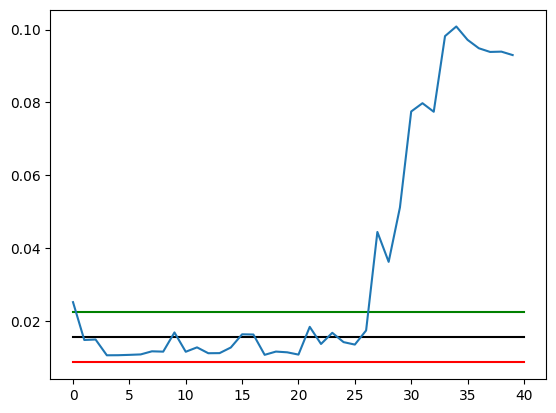

In [12]:
plt.plot([0, 40], [median_vec[1], median_vec[1]],'k')
plt.plot([0, 40], [median_vec[0], median_vec[0]],'r')
plt.plot([0, 40], [median_vec[2], median_vec[2]],'g')

plt.plot(synced_time_vector[0:40] - behavior_time_vector[0:40])


(-0.4, 0.4)

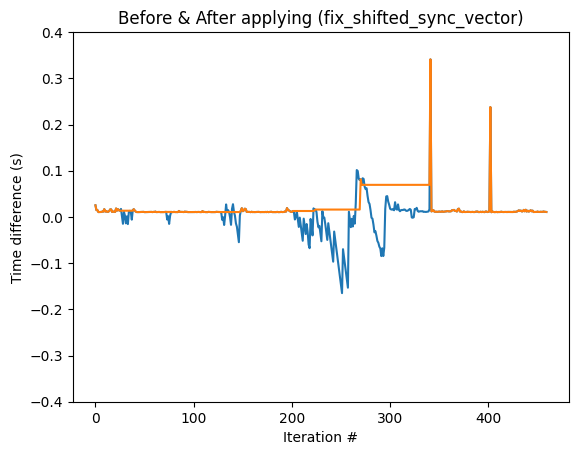

In [16]:
synced_time_vector3,_ = ephys_fix_sync_code.fix_shifted_sync_vector(synced_time_vector2, behavior_time_vector, shift_vec)

plt.plot(synced_time_vector2 - behavior_time_vector[:synced_time_vector2.shape[0]])
plt.plot(synced_time_vector3 - behavior_time_vector[:synced_time_vector3.shape[0]])


plt.xlabel('Iteration #')
plt.ylabel('Time difference (s)')
plt.title('Before & After applying (fix_shifted_sync_vector)')

plt.ylim([-0.4,0.4])



(-0.4, 0.4)

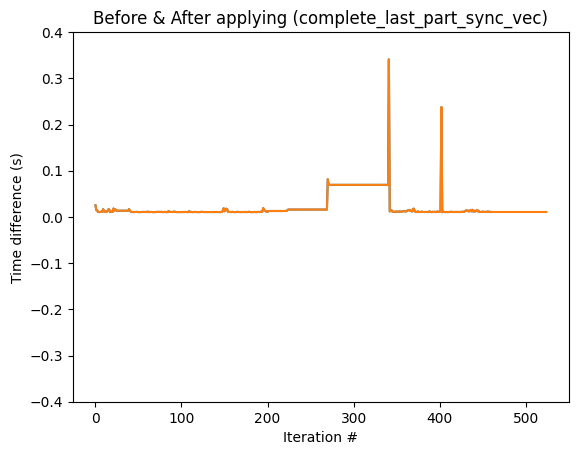

In [17]:
synced_time_vector4,_ =\
    ephys_fix_sync_code.complete_last_part_sync_vec(synced_time_vector3, behavior_time_vector)

plt.plot(synced_time_vector3 - behavior_time_vector[:synced_time_vector3.shape[0]])
plt.plot(synced_time_vector4 - behavior_time_vector[:synced_time_vector4.shape[0]])


plt.xlabel('Iteration #')
plt.ylabel('Time difference (s)')
plt.title('Before & After applying (complete_last_part_sync_vec)')

plt.ylim([-0.4, 0.4])

(-0.4, 2.2)

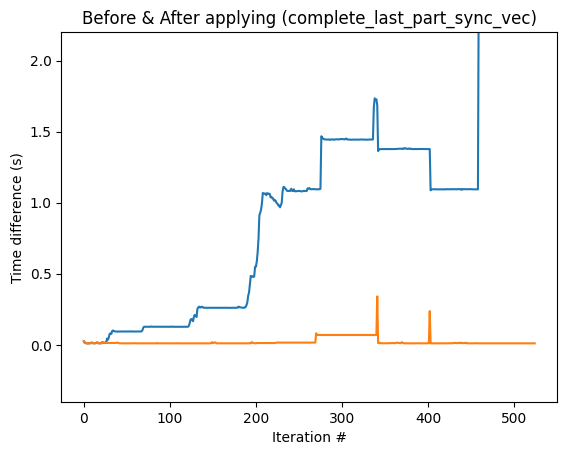

In [21]:
synced_time_vector4,_ =\
    ephys_fix_sync_code.complete_last_part_sync_vec(synced_time_vector3, behavior_time_vector)

plt.plot(synced_time_vector - behavior_time_vector[:synced_time_vector.shape[0]])
plt.plot(synced_time_vector4 - behavior_time_vector[:synced_time_vector4.shape[0]])


plt.xlabel('Iteration #')
plt.ylabel('Time difference (s)')
plt.title('Before & After applying (complete_last_part_sync_vec)')

plt.ylim([-0.4, 2.2])